In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
pd.options.mode.chained_assignment = None
sns.set()

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
df_covid = pd.read_csv(r"C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\cleaned\may_Wrangled_CA.csv", index_col='date', parse_dates=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 840 entries, 2020-01-25 to 2022-05-13
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          840 non-null    object 
 1   cases          840 non-null    int64  
 2   deaths         840 non-null    float64
 3   new_cases      840 non-null    float64
 4   pct_change     839 non-null    float64
 5   seven_day_ave  840 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 45.9+ KB


In [4]:
df_covid.describe()

,cases,deaths,new_cases,pct_change,seven_day_ave
count,8.400000e+02,840.000000,840.000000,839.000000,840.000000
mean,3.345382e+06,43970.794048,11132.892857,0.021531,11132.376369
std,2.882682e+06,31484.949465,22467.353795,0.081515,19149.900160
min,1.000000e+00,0.000000,-1607.000000,-0.000421,0.000000
25%,6.639915e+05,12098.750000,1609.500000,0.000676,2624.035714
50%,3.639736e+06,57456.000000,4294.000000,0.003142,5391.142857
75%,4.828592e+06,70769.000000,10297.750000,0.015624,9630.071429
max,9.351630e+06,90959.000000,227972.000000,1.363636,119536.142857


### Make data stationary

For the first time series model I will be trying ARIMA, which requires stationary data. To achieve this I will difference the data.

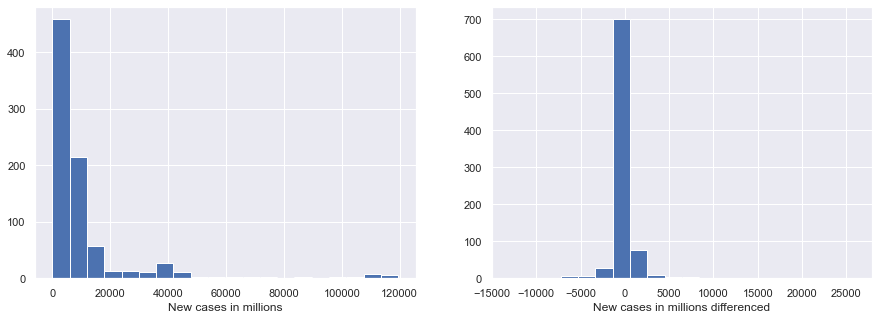

In [5]:
# Try differencing the data to see how it will affect the distribution
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(x=df_covid.seven_day_ave, bins=20)
ax[0].set_xlabel('New cases in millions')
ax[1].hist(x=df_covid.seven_day_ave.diff().dropna(), bins=20)
ax[1].set_xlabel('New cases in millions differenced')
plt.show()

A differencing of 1 appears to be normaly distributed

In [6]:
# Check for stationarity with adfuller test
adfuller(df_covid.seven_day_ave.diff().dropna())

(-7.135536515003967,
 3.4288819789659017e-10,
 20,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 14148.46982435194)

With one order of differencing the covid data appears to be stationary at CV=1%

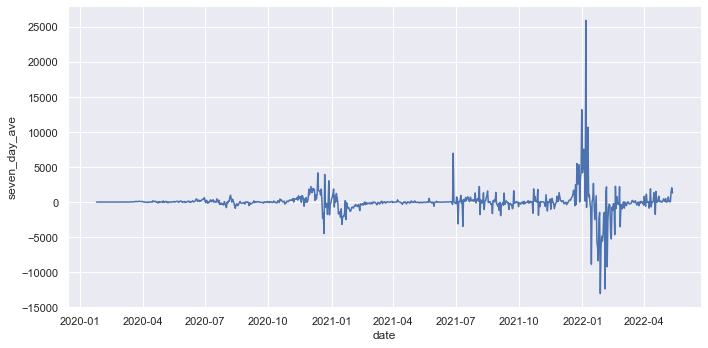

In [7]:
# Now plot differenced data over time
sns.relplot(kind='line', x=df_covid.iloc[:-1].index, y=df_covid['seven_day_ave'].diff().dropna(), aspect=2)

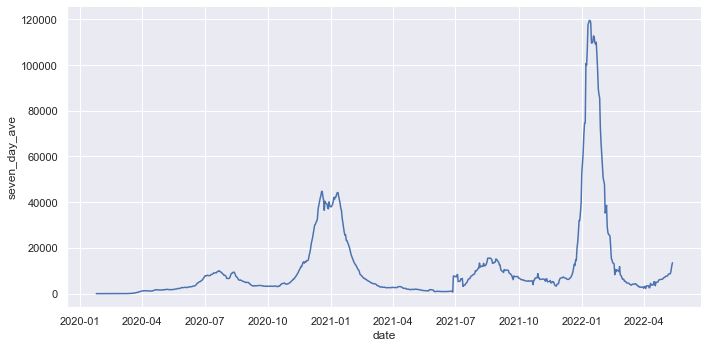

In [8]:
# Standard plot of CA data over time
sns.relplot(data=df_covid, kind='line', x=df_covid.index, y=df_covid['seven_day_ave'], aspect=2)

### Compare different levels of differencing

In [9]:
# Now look at data with differencing 1-3, looking at the acf and running adfuller for each
def check_diff(df, col): 
    fig, ax = plt.subplots(3,2, figsize=(25,15))
    
    ax[0,0].plot(df[col].diff().dropna())
    acf1 = plot_acf(df[col].diff().dropna(), lags=7, ax=ax[0,1])
    ax[0,0].set_title('Differencing = 1')

    ax[1,0].plot(df[col].diff().diff().dropna())
    acf2 = plot_acf(df[col].diff().diff().dropna(), lags=7, ax=ax[1,1])
    ax[1,0].set_title('Differencing = 2')

    ax[2,0].plot(df[col].diff().diff().diff().dropna())
    acf3 = plot_acf(df[col].diff().diff().diff().dropna(), lags=7, ax=ax[2,1])
    ax[2,0].set_title('Differencing = 3')

    test_lag1 = adfuller(df[col].diff().dropna())
    test_lag2 = adfuller(df[col].diff().diff().dropna())
    test_lag3 = adfuller(df[col].diff().diff().diff().dropna())

    print('Lag 1 p-value:', test_lag1[1])
    print('Lag 2 p-value:', test_lag2[1])
    print('Lag 3 p-value:', test_lag3[1])

Lag 1 p-value: 3.4288819789659017e-10
Lag 2 p-value: 2.7310586449862545e-10
Lag 3 p-value: 6.244632410911124e-23


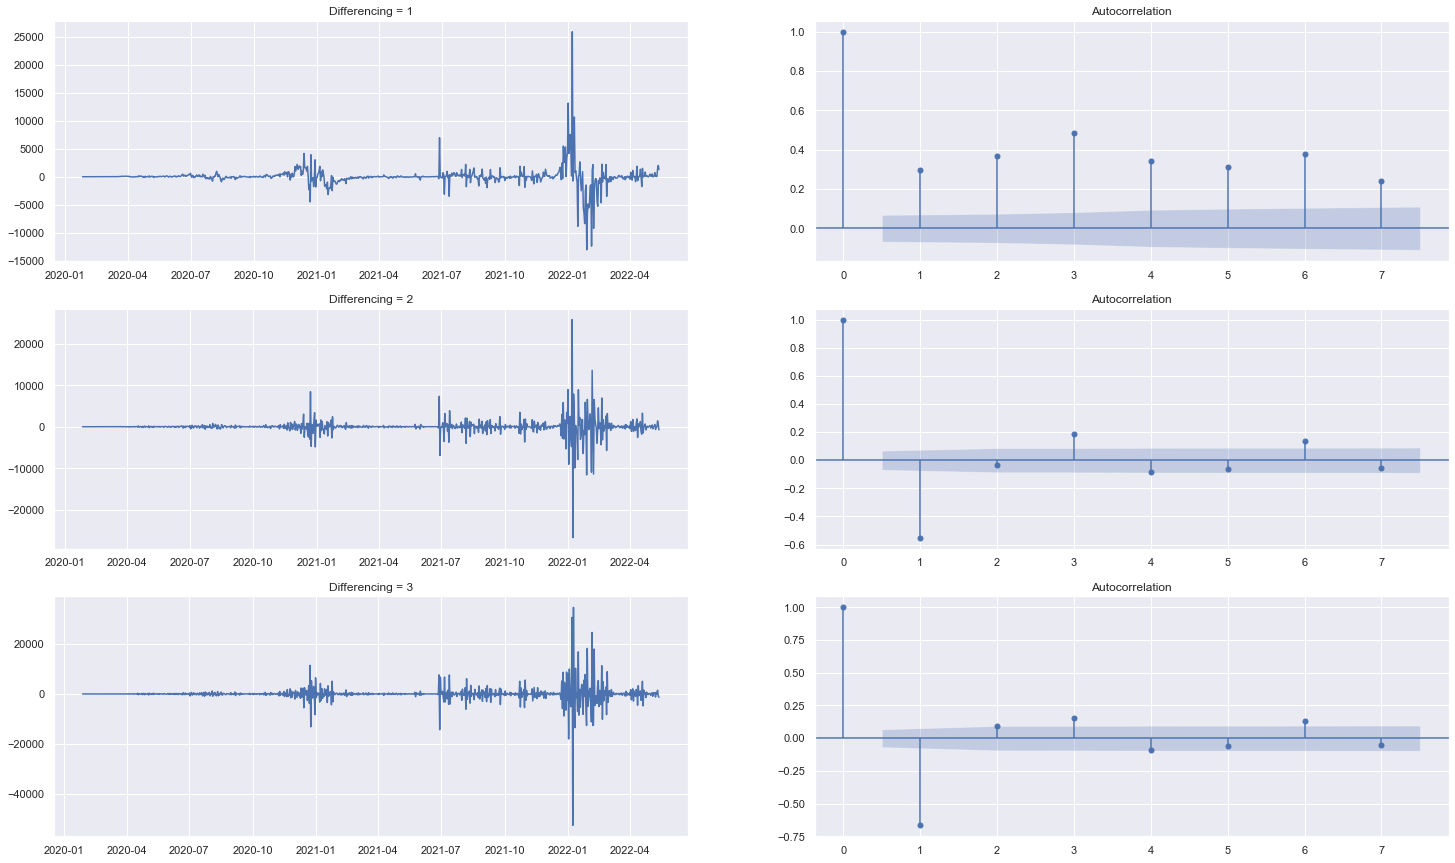

In [10]:
check_diff(df_covid, 'seven_day_ave')

It looks like differencing of 1 is sufficient

## Check for seasonality in data

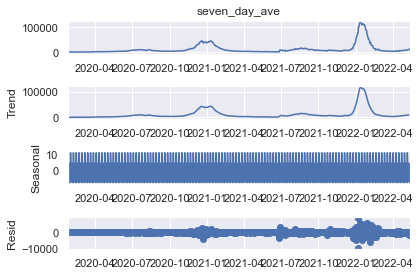

In [11]:
# Use seasonal decompose to check for seasonality
decompose = seasonal_decompose(df_covid.seven_day_ave)
decompose.plot();

## Import resampled covid data for comparison with hospital data

In [12]:
df_covid = pd.read_csv(r"C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\cleaned\Wrangled_CA_resample.csv", index_col='date', parse_dates=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2020-07-31 to 2022-05-13
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cases          93 non-null     float64
 1   deaths         93 non-null     float64
 2   new_cases      93 non-null     float64
 3   pct_change     93 non-null     float64
 4   seven_day_ave  93 non-null     float64
dtypes: float64(5)
memory usage: 4.4 KB


In [13]:
df_covid.describe()

,cases,deaths,new_cases,pct_change,seven_day_ave
count,9.300000e+01,93.000000,93.000000,93.000000,93.000000
mean,4.237080e+06,55235.649770,13609.771121,0.004681,13616.553087
std,2.643064e+06,25783.409378,21169.218170,0.005798,20980.251627
min,5.022730e+05,9222.000000,893.285714,0.000236,901.693878
25%,2.513826e+06,27640.000000,3518.857143,0.000796,3627.183673
50%,3.804508e+06,63225.857143,6394.428571,0.002021,6360.816327
75%,5.052682e+06,74148.714286,11928.142857,0.005947,11945.204082
max,9.315299e+06,90789.285714,118460.285714,0.024459,114365.755102


## Examine hospital data

In [14]:
df_hospital = pd.read_csv(r"C:\Users\blake\Documents\Springboard\Github\Capstone2\Covid_Final\Capstone_2_Covid_TimeSeries\data\cleaned\Wrangled_CA_hospitals.csv", index_col='collection_week', parse_dates=True)
df_hospital.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2020-07-31 to 2021-11-26
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bed_availability  70 non-null     float64
 1   total_occupancy   70 non-null     float64
 2   covid_occupancy   70 non-null     float64
 3   covid_rato        70 non-null     float64
 4   total_ratio       70 non-null     float64
dtypes: float64(5)
memory usage: 3.3 KB


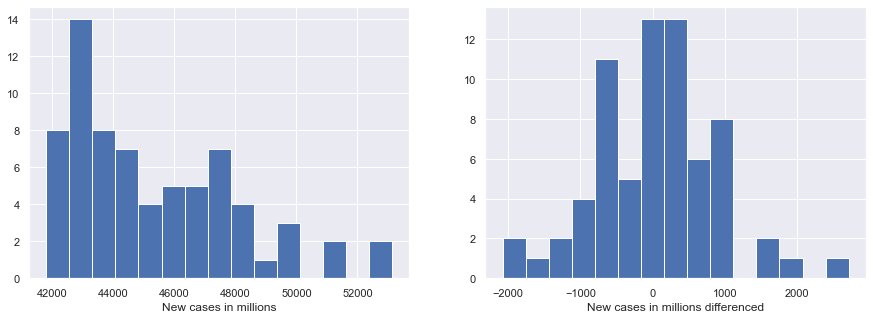

In [15]:
# Try differencing the data to see how it will affect the distribution
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(x=df_hospital.total_occupancy, bins=15)
ax[0].set_xlabel('New cases in millions')
ax[1].hist(x=df_hospital.total_occupancy.diff().dropna(), bins=15)
ax[1].set_xlabel('New cases in millions differenced')
plt.show()

In [16]:
# Check for stationarity with adfuller test
adfuller(df_hospital.total_occupancy.diff().dropna())

(-5.364166338241125,
 4.026432960173348e-06,
 0,
 68,
 {'1%': -3.530398990560757,
  '5%': -2.9050874099328317,
  '10%': -2.5900010121107266},
 929.1821179842665)

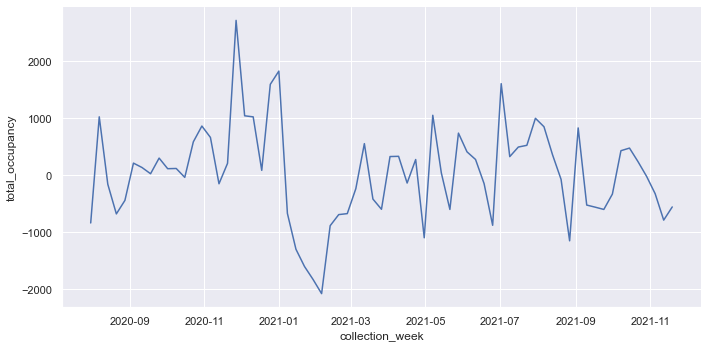

In [17]:
# Now plot differenced data over time
sns.relplot(kind='line', x=df_hospital.iloc[:-1].index, y=df_hospital.total_occupancy.diff().dropna(), aspect=2)

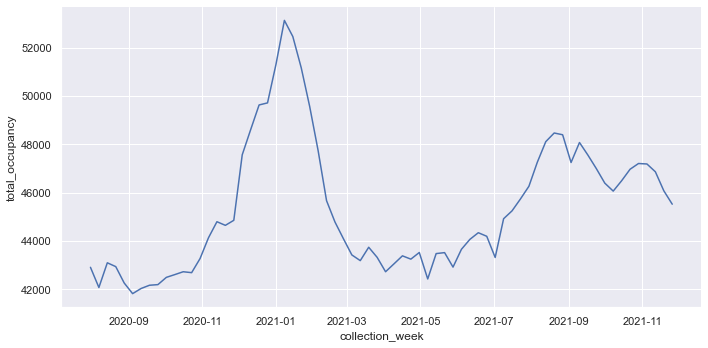

In [18]:
# Standard plot of CA data over time
sns.relplot(data=df_hospital, kind='line', x=df_hospital.index, y=df_hospital.total_occupancy, aspect=2)

Lag 1 p-value: 4.026432960173348e-06
Lag 2 p-value: 3.9001049456586095e-14
Lag 3 p-value: 1.0149592706705433e-17


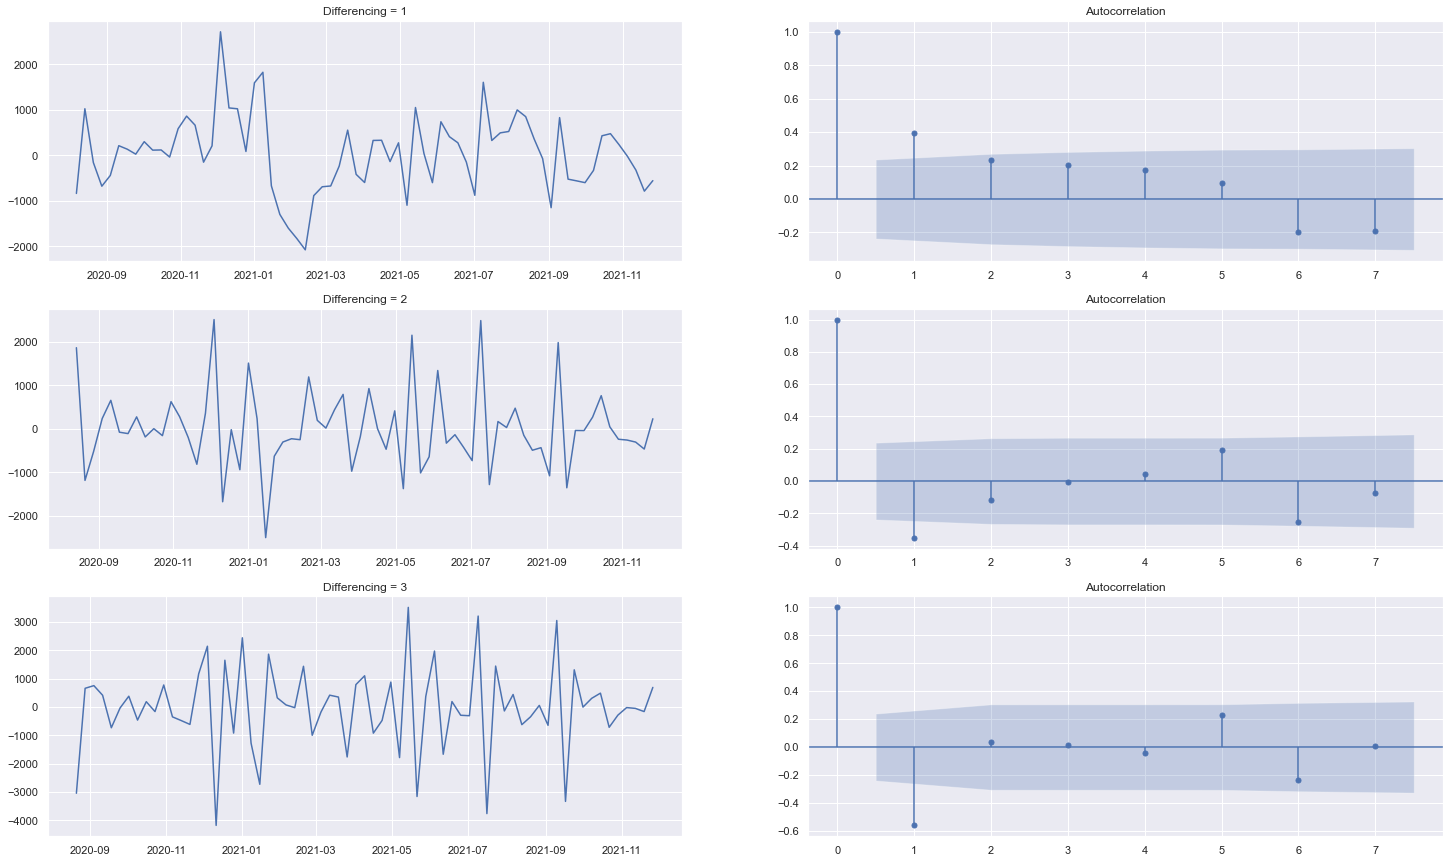

In [19]:
check_diff(df_hospital, 'total_occupancy')

Differencing of 2 seems to be sufficient

### Remove outliers from hospital data

In [20]:
diff = df_hospital['total_occupancy'].diff().diff().dropna()

In [21]:
cutt_off = diff.std()*2.5
cutt_off

2321.1097997792235

In [22]:
outliers = diff.loc[abs(diff)>cutt_off]
outliers

collection_week
2020-12-04    2505.9
2021-01-15   -2494.9
2021-07-09    2482.7
Name: total_occupancy, dtype: float64

In [23]:
df_hospital.loc[df_hospital.index.isin(outliers.index), 'total_occupancy'] = df_hospital.total_occupancy.median()

## Run SLR on hospital occupancy

In [24]:
exog = sm.add_constant(df_covid.new_cases, prepend=False)
exog = exog.loc[:'2021-11-26']
endog = df_hospital.total_occupancy

reg = sm.OLS(endog, exog)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        total_occupancy   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     79.40
Date:                Fri, 20 May 2022   Prob (F-statistic):           4.90e-13
Time:                        12:46:00   Log-Likelihood:                -621.45
No. Observations:                  70   AIC:                             1247.
Df Residuals:                      68   BIC:                             1251.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
new_cases      0.1819      0.020      8.910      0.0

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


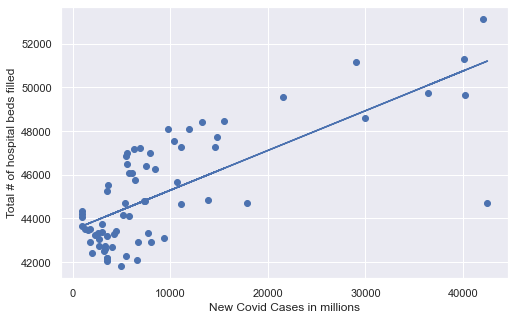

In [25]:
pred = res.predict()

plt.figure(figsize=(8,5))
plt.scatter(df_covid.new_cases.loc[:'2021-11-26'], df_hospital.total_occupancy)
plt.xlabel('New Covid Cases in millions')
plt.ylabel('Total # of hospital beds filled')
plt.plot(df_covid.new_cases.loc[:'2021-11-26'], pred)

The regression reseults show that there is a strong relationship between new covid infections and total hospital occupancy in California. To be specific, the coeficient for new_cases is 0.1819, indicating that on average, for roughly every 5 new covid cases in a given week one additional hospital bed will be filled. This coeficient is also statistically significant at 99% confidence.